# Discourse Relation Classification with XLM-RoBERTa-Base

Trains and evaluates **xlm-roberta-base** on DISRPT 2025 Task 3 using two argument orderings:
- Natural  
- Relation-directed  

DISRPT 2025: https://sites.google.com/view/disrpt2025/  

Our Work: https://github.com/CLaC-Lab/DISRPT-2025  

Author: Nawar Turk


# 1. Setup


## 1.1. Install & Import Libraries

In [ ]:
import os
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from collections import Counter
import shutil  # for making the zip archive
from google.colab import files  # for downloading in Colab
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt
import random
import torch
from transformers import set_seed
from datasets import Dataset
from sklearn.metrics import classification_report

In [ ]:
SEED = 42

In [ ]:
def set_global_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TOKENIZERS_PARALLELISM'] = 'false'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    print(f"✅ Global seed set: {seed}")

set_global_seed(SEED)

✅ Global seed set: 42


## 1.2. Load Datasets

In [ ]:
# TODO: Update paths to where you stored the DISRPT datasets
train_dataset = pd.read_csv('path/to/train_dataset.csv')
dev_dataset = pd.read_csv('path/to/dev_dataset.csv')

Mounted at /content/drive


# 2. Helper Functions

## 2.1. Plot Function

In [ ]:
def plot_metrics_per_epoch(trainer):
    """
    Plots train/validation loss and validation accuracy per epoch, highlighting best accuracy.
    """
    log_history = trainer.state.log_history
    train_losses = []
    val_losses = []
    val_accuracies = []
    epochs = []

    for entry in log_history:
        if 'eval_loss' in entry:
            epoch = entry.get('epoch')
            eval_loss = entry['eval_loss']
            val_acc = entry.get('eval_accuracy')

            # Look for the training loss in the same or previous entry
            train_loss = None
            for e in reversed(log_history[:log_history.index(entry)+1]):
                if 'loss' in e and e.get('epoch') == epoch:
                    train_loss = e['loss']
                    break

            if epoch is not None and train_loss is not None:
                epochs.append(epoch)
                train_losses.append(train_loss)
                val_losses.append(eval_loss)
                val_accuracies.append(val_acc)

    # Plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    ax1.plot(epochs, val_losses, label="Val Loss", color="orange", marker='x')
    ax1.set_xticks(range(1, len(epochs) + 1))
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylim(0.0, 1.0)
    ax2.plot(epochs, val_accuracies, label="Val Accuracy", color="green", marker='s')
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="upper right")

    # Find best epoch and accuracy
    best_idx = val_accuracies.index(max(val_accuracies))
    best_epoch = epochs[best_idx]
    best_acc = val_accuracies[best_idx]
    # Plot marker and label
    ax2.plot(best_epoch, best_acc, 'ro')  # red dot
    ax2.text(best_epoch, best_acc + 0.02, f'{best_acc:.2f}', color='red', ha='center')

    plt.title("Training vs Validation Loss and Accuracy per Epoch")
    plt.tight_layout()
    plt.show()

## 2.2. Train Function

In [ ]:

def train (model_name, train, dev, arg1_key, arg2_key):
  """
  Fine-tunes a Hugging Face transformer model for discourse relation classification.

  - Prepares and tokenizes train/dev datasets
  - Trains with early stopping and evaluates on the dev set
  - Saves confusion matrix, predictions, and model files
  - Prints overall, per-language, and per-framework metrics
  """

  # prepare_datasets_for_training
  train_df = pd.DataFrame(train)
  dev_df = pd.DataFrame(dev)

  unique_labels = sorted(train_df['label_text'].unique())
  label2id = {label: i for i, label in enumerate(unique_labels)}
  id2label = {i: label for i, label in enumerate(unique_labels)}

  train_df['label'] = train_df['label_text'].map(label2id)
  dev_df['label'] = dev_df['label_text'].map(label2id)

  # Tokenization function
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  def tokenize(examples):
    return tokenizer(
        examples[arg1_key],
        examples[arg2_key],
        truncation=True,
        padding=True,
        max_length=512
        )

  train_dataset = Dataset.from_pandas(train_df)
  dev_dataset = Dataset.from_pandas(dev_df)
  train_dataset = train_dataset.map(tokenize, batched=True)
  dev_dataset = dev_dataset.map(tokenize, batched=True)

  # Load a model
  model = AutoModelForSequenceClassification.from_pretrained(
  model_name,
  num_labels=len(unique_labels),
  id2label=id2label,
  label2id=label2id
  )

  output_dir = f"./{model_name.replace('/', '-')}-discourse-OD-{arg1_key}"
  training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    num_train_epochs=20,
    weight_decay=0.01,
    warmup_ratio=0.1,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=3,
    seed=SEED,
    data_seed=SEED,
    dataloader_num_workers=0,   # deterministic
    fp16=True
    )

  def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    return {"accuracy": accuracy, "f1_macro": f1_macro, "f1_micro": f1_micro}

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=dev_dataset,
      processing_class=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
  )

  trainer.train()

  predictions = trainer.predict(dev_dataset)
  preds = np.argmax(predictions.predictions, axis=-1)

  # Convert to DataFrame and add predictions
  dev_with_predictions = dev_dataset.to_pandas().reset_index(drop=True)
  dev_with_predictions['pred_label_id'] = preds
  dev_with_predictions['pred_label'] = dev_with_predictions['pred_label_id'].map(id2label)

  # Create confusion matrix
  confusion_matrix = pd.crosstab(
      dev_with_predictions['label_text'],
      dev_with_predictions['pred_label'],
      margins=False  # No totals for averaging
  )

  # Save as CSV
  filename = f"confusion_matrix_{arg1_key}{model_name.replace('/','-')}.csv"
  confusion_matrix.to_csv(filename)
  print(f"Saved: {filename}")

  true_labels = dev_with_predictions['label_text'].values
  pred_labels = dev_with_predictions['pred_label'].values
  # Save CSV
  predictions_file = f"predictions_{model_name.replace('/','-')}_{arg1_key}.csv"
  dev_with_predictions.to_csv(predictions_file, index=False)
  print(f"💾 Saved predictions to: {predictions_file}")

  # Calculate comprehensive metrics using sklearn
  accuracy = accuracy_score(true_labels, pred_labels)
  f1_macro = f1_score(true_labels, pred_labels, average='macro')
  f1_micro = f1_score(true_labels, pred_labels, average='micro')
  f1_weighted = f1_score(true_labels, pred_labels, average='weighted')

  print(f"📊 {model_name.upper()} on DEV RESULTS:")
  print(f"   Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
  print(f"   F1-Macro:    {f1_macro:.4f}")
  print(f"   F1-Micro:    {f1_micro:.4f}")
  print(f"   F1-Weighted: {f1_weighted:.4f}")

  # Optional: Print detailed classification report
  if len(id2label) <= 20:  # Only for reasonable number of classes
      print(f"\n📋 Classification Report:")
      target_names = [id2label[i] for i in sorted(id2label.keys())]
      print(classification_report(true_labels, pred_labels,
                                target_names=target_names,
                                digits=4, zero_division=0))

  def lang_accuracy(data):
   languages = data['lang'].unique()
   for lang in languages:
       lang_data = data[data['lang'] == lang]
       lang_acc = (lang_data['label_text'] == lang_data['pred_label']).mean().round(3)
       print(f"{lang}: {lang_acc*100:.1f}%")

  def framework_accuracy(data):
    frameworks = data['framework'].unique()
    for fw in frameworks:
        fw_data = data[data['framework'] == fw]
        fw_acc = (fw_data['label_text'] == fw_data['pred_label']).mean().round(3)
        print(f"{fw}: {fw_acc*100:.1f}%")

  lang_accuracy(dev_with_predictions)
  framework_accuracy(dev_with_predictions)

  # Save Model
  save_path = f"./{model_name.replace('/', '-')}-discourse-final-{arg1_key}"
  trainer.save_model(save_path)
  trainer.tokenizer.save_pretrained(save_path)
  zip_path = shutil.make_archive(save_path, 'zip', save_path)

  return trainer, dev_with_predictions

# 3. Experiments



## 3.1. Experiment 1 - Natural Order Arguments

In [ ]:
model_name = "xlm-roberta-base"
arg1_key = 'unordered_arg1'
arg2_key = 'unordered_arg2'

Map:   0%|          | 0/169284 [00:00<?, ? examples/s]

Map:   0%|          | 0/27566 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,1.761200,1.202943,0.623050,0.580618,0.623050
2,1.140100,1.139083,0.643474,0.620299,0.643474
3,0.993200,1.086109,0.653958,0.630536,0.653958
4,0.839400,1.116329,0.649496,0.633574,0.649496
5,0.705800,1.194740,0.651781,0.631401,0.651781
6,0.580900,1.297144,0.647247,0.628875,0.647247


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

Saved: confusion_matrix_unordered_arg1xlm-roberta-base.csv
💾 Saved predictions to: predictions_xlm-roberta-base_unordered_arg1.csv
📊 XLM-ROBERTA-BASE on DEV RESULTS:
   Accuracy:    0.6540 (65.40%)
   F1-Macro:    0.6305
   F1-Micro:    0.6540
   F1-Weighted: 0.6491

📋 Classification Report:
               precision    recall  f1-score   support

  alternation     0.8800    0.5670    0.6897       194
  attribution     0.9171    0.9120    0.9145       886
       causal     0.6765    0.6488    0.6624      2924
      comment     0.5280    0.4207    0.4682       920
   concession     0.6149    0.6491    0.6316      1294
    condition     0.8383    0.6883    0.7560       738
  conjunction     0.5892    0.6828    0.6326      4555
     contrast     0.6087    0.4713    0.5312      1254
  elaboration     0.6432    0.7194    0.6792      6412
  explanation     0.5644    0.2601    0.3561      1061
        frame     0.5030    0.4178    0.4565       797
         mode     0.6776    0.5712    0.6199  

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


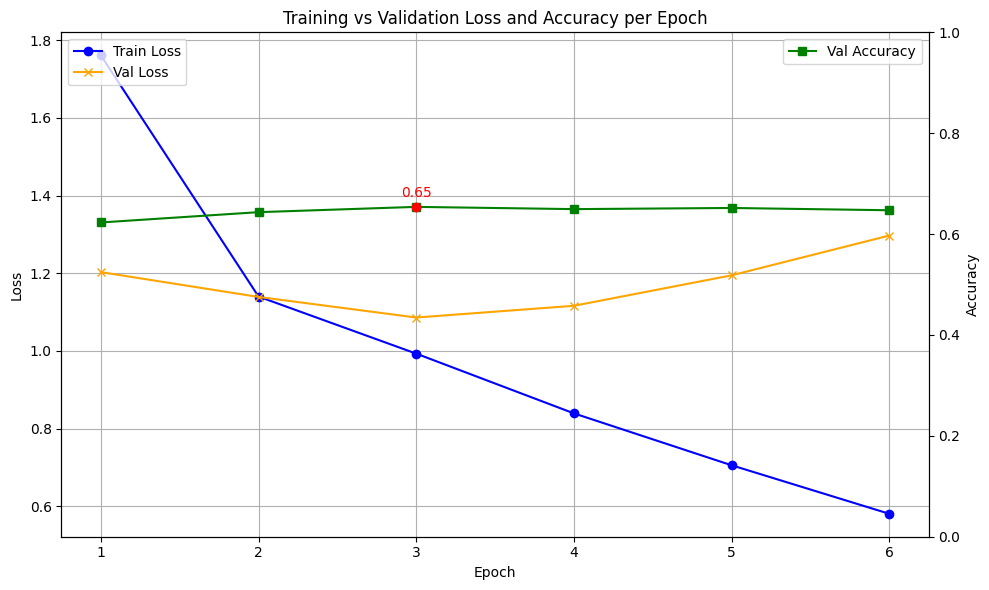

In [ ]:
trainer, dev_with_predictions = train(model_name, train_dataset, dev_dataset, arg1_key, arg2_key)
plot_metrics_per_epoch(trainer)



---



## 3.2. Experiment 2 – Relation-Directed Order Arguments

In [ ]:
model_name = "xlm-roberta-base"
arg1_key = 'ordered_arg1'
arg2_key = 'ordered_arg2'

Map:   0%|          | 0/169284 [00:00<?, ? examples/s]

Map:   0%|          | 0/27566 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,1.830300,1.251495,0.609700,0.562181,0.609700
2,1.176600,1.159893,0.637343,0.613853,0.637343
3,1.020000,1.104566,0.645687,0.629135,0.645687
4,0.865300,1.132275,0.649206,0.632670,0.649206
5,0.725400,1.223138,0.648335,0.631846,0.648335
6,0.595600,1.316150,0.639701,0.623864,0.639701


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

Saved: confusion_matrix_ordered_arg1xlm-roberta-base.csv
💾 Saved predictions to: predictions_xlm-roberta-base_ordered_arg1.csv
📊 XLM-ROBERTA-BASE on DEV RESULTS:
   Accuracy:    0.6457 (64.57%)
   F1-Macro:    0.6291
   F1-Micro:    0.6457
   F1-Weighted: 0.6444

📋 Classification Report:
               precision    recall  f1-score   support

  alternation     0.8168    0.5515    0.6585       194
  attribution     0.9240    0.9199    0.9219       886
       causal     0.5793    0.6754    0.6237      2924
      comment     0.5411    0.4435    0.4875       920
   concession     0.5986    0.6074    0.6030      1294
    condition     0.7976    0.7263    0.7603       738
  conjunction     0.5756    0.6814    0.6240      4555
     contrast     0.5474    0.5295    0.5383      1254
  elaboration     0.7117    0.6496    0.6792      6412
  explanation     0.4519    0.3233    0.3769      1061
        frame     0.4757    0.4668    0.4712       797
         mode     0.7737    0.5434    0.6384      

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


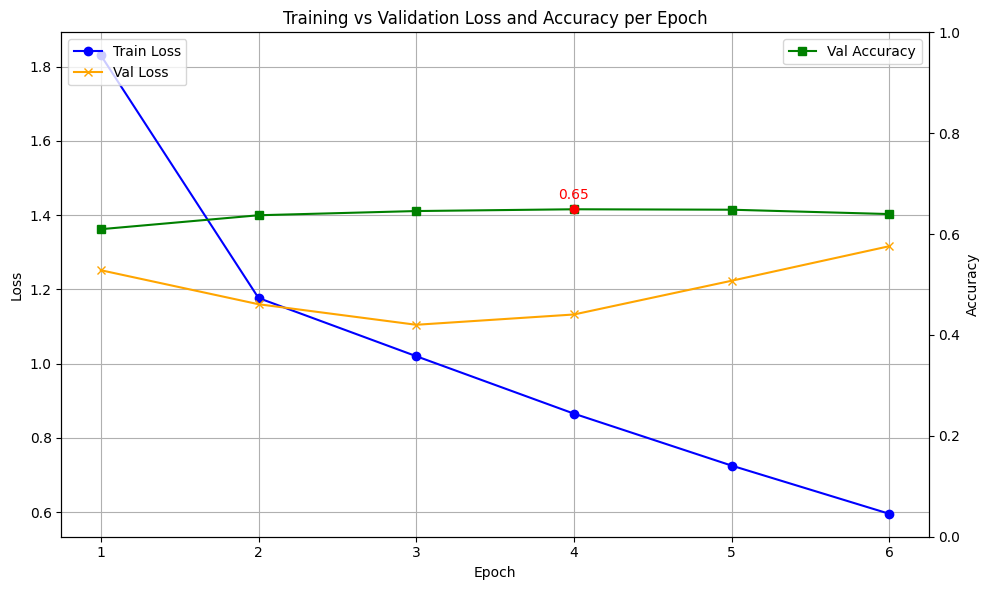

In [ ]:
trainer, dev_with_predictions = train(model_name, train_dataset, dev_dataset, arg1_key, arg2_key)
plot_metrics_per_epoch(trainer)